In [1]:
!pip install pvlib==0.10.4

In [2]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
sns.set(font_scale=1.5, style='white')
mpl.rcParams['figure.figsize'] = (12, 8)
print(f'pvlib version: {pvlib.__version__}')

pvlib version: 0.10.4


# Self Shade Demo for PVPMC 2024
We compare simple models of linear and non-linear shade loss versus observations. We use [`pvlib.bifacial.infinite_sheds.get_irradiance`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.bifacial.infinite_sheds.get_irradiance.html) to give us shaded fraction for the whole array/row, then manually calculate shaded fraction for each course going up the row.

>NOTE: A _course_ is group of modules 1-module high running across a row, _EG_: a 2P tracker has 2 courses. 

For the shade loss models used here to be valid, a given string of modules must only be in a single course. See the example diagram below of a 3P system:

<img src="images/3P_top_view2.png" width="600"/>

As an example of calculating shaded fraction for each course, in the 3P crystalline array above (`eff_row_side_num_mods = 3`), with an array shaded fraction of 0.5, the shaded fraction in each course, starting from the bottom, would be: 1.0, 0.5, 0.0. 

With a shaded fraction of 1/6 (0.1667), the shaded fraction in each course would be: 0.5, 0.0, 0.0, as shown in the diagram below:

<img src="images/3P_side_view2.png" width="600"/>

And here's a function to calculate shaded fraction for each course:

In [3]:
def shade_fractions(fs_array, eff_row_side_num_mods):
    """
    Shade fractions on each _course_ of a rack or tracker.

    Parameters
    ----------
    fs_array : numeric
        Scalar or vector of shade fractions for the entire rack or tracker. Zero (0)
        is unshaded and one (1) is fully shaded.
    eff_row_side_num_mods : int
        Number of courses in the rack as modules. EG: a 2P tracker has 2 courses.

    Returns
    -------
    Array with the shade fraction on each course.
    """
    fs_course = np.clip([
        fs_array * eff_row_side_num_mods - course 
        for course in range(eff_row_side_num_mods)], 0, 1)
    return fs_course

# test examples
shade_fractions(np.array([0.5, 0.6, 2/3]), 3)

array([[1. , 1. , 1. ],
       [0.5, 0.8, 1. ],
       [0. , 0. , 0. ]])

Here's the same thing, but iterating through a range of array shaded fractions (`fs_array`) and plotting the output to confirm it makes sense. Feel free to change the effective number of modules on the side of the row (`eff_row_side_num_mods`).

,0,1,2
fs_array,,,
0.000000,0.000000,0.0,0.000000
0.010101,0.030303,0.0,0.000000
0.020202,0.060606,0.0,0.000000
0.030303,0.090909,0.0,0.000000
0.040404,0.121212,0.0,0.000000
...,...,...,...
0.959596,1.000000,1.0,0.878788
0.969697,1.000000,1.0,0.909091
0.979798,1.000000,1.0,0.939394


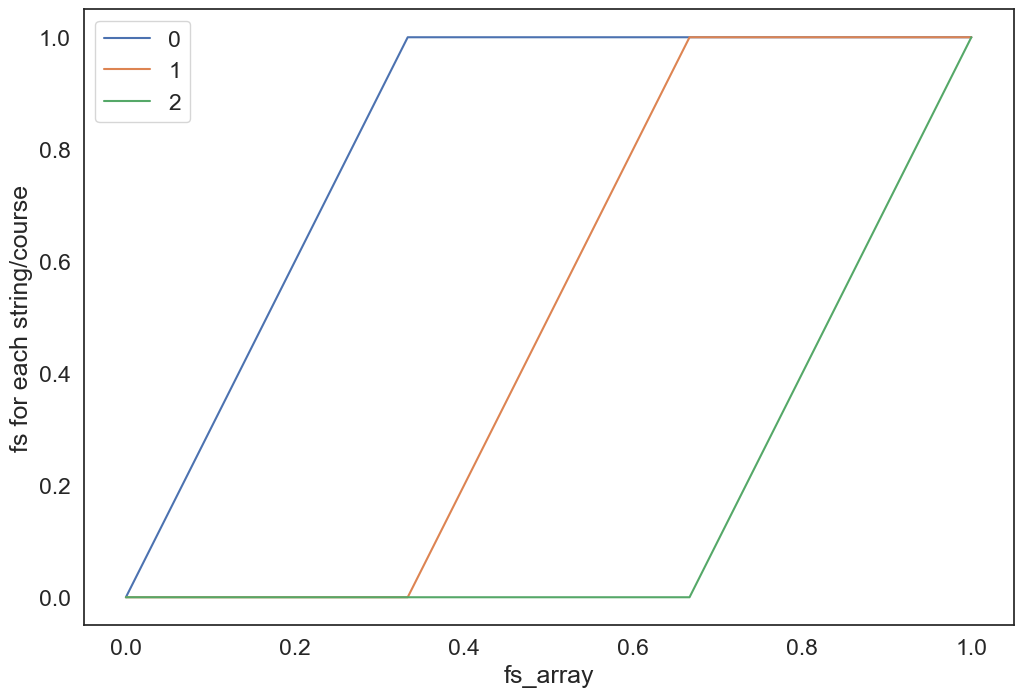

In [4]:
eff_row_side_num_mods = 3 # <-- change this to try other numbers of courses/strings per row
fs_array = np.linspace(0, 1, 100)
output = shade_fractions(fs_array, eff_row_side_num_mods)
df = pd.DataFrame(output.T, index = fs_array)
df.index.name = 'fs_array'
df.plot()
plt.ylabel('fs for each string/course')
df

For non-linear shade, we calculate losses using the simple piecewise shading model from [1], generalized for module designs with any number of cells going vertically up the module, e.g., `n_cells_up = 12` for a traditional module with 72 whole cells, or `n_cells_up = 24` or `26` for many modules with half-cut cells.

>Note: this model approximates the electrical impacts of partial shade, but it does it with effective irradiance. Because of this, the `shade_loss` fraction is best applied to POA irradiance that goes into a dc power model. For linear dc power models, like `pvlib.pvsystem.pvwatts_dc()`, you would get the same result applying it to power, but for non-linear models, it needs to be applied to irradiance. 

[1] Anderson, Kevin. 2020. Maximizing Yield with Improved Single-Axis Backtracking on Cross-Axis Slopes: Preprint. Golden, CO: National Renewable Energy Laboratory. NREL/CP-5K00-76023. https://www.nrel.gov/docs/fy20osti/76023.pdf.

In [5]:
def non_linear_shade(n_cells_up, fs, fd):
    """
    Simple non-linear shade model.

    Assume shade loss is linear as direct shade moves from bottom through
    first cell, and then only diffuse for remainder of module up to the top.
    EG: If there are 10 cells, and ``fs`` is 0.05, the bottom cell is only
    half shaded, then the loss would be 50% of the direct irradiance. If
    80% of POA global on module is direct irradiance, IE: ``fd = 0.2``,
    then loss would be 40%. When the direct shade line reaches 10%, one
    cell is completely shaded, then the loss is 80%, and there's only diffuse
    light on the module. Any direct shade above the 1st cell has the same loss.

    Parameters
    ----------
    n_cells_up : int
        Number of cells vertically up
    fs : float
        Fraction of shade on module, 1 is fully shaded
    fd : numeric
        Diffuse fraction

    Returns
    -------
    Array of shade loss same size as ``fd``
    """
    pnorm = np.where(fs < 1/n_cells_up, 1 - (1 - fd)*fs*n_cells_up, fd)
    shade_loss = 1 - pnorm
    return shade_loss

And here's a example of shade loss for the full range of shaded fraction (0 to 1) on a module with `n_cells_up = 12` and a diffuse fraction of 0.2. For shaded fractions from 0 to 1/12, where the bottom row of cells are partially shaded, losses increase linearly with the loss in direct irradiance. Beyond that point, power is assumed to be limited to the lower power cells in the module, which only recieve diffuse irradiance. 

Text(0, 0.5, 'Non-linear Shade Loss')

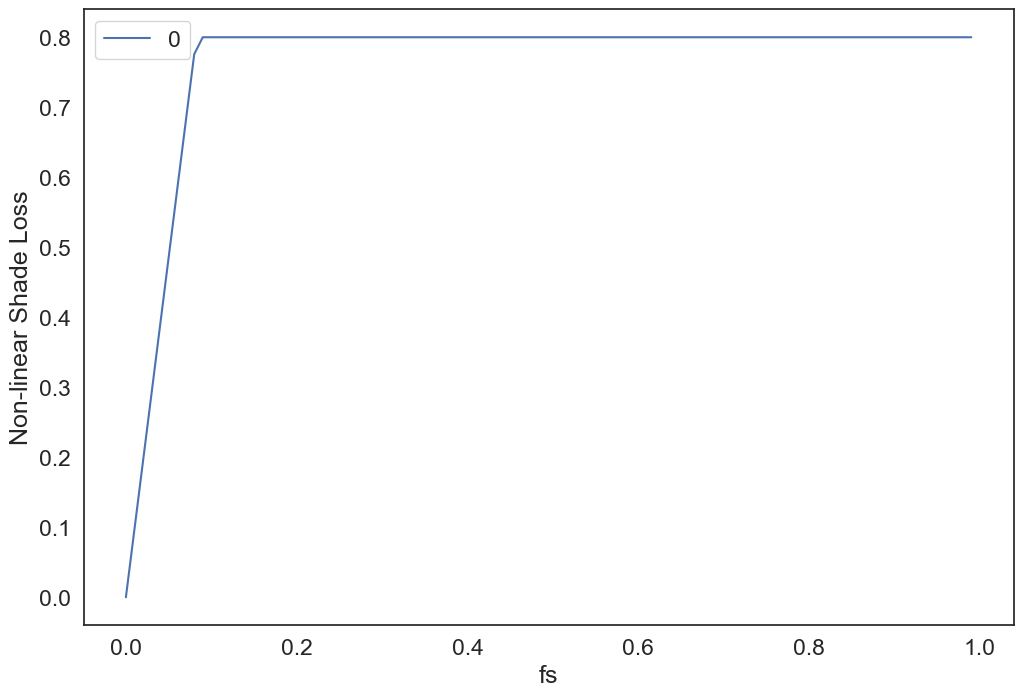

In [6]:
n_cells_up = 12 
fd = 0.2
output = non_linear_shade(n_cells_up, np.linspace(0, 1, 100), fd)
df = pd.DataFrame(output.T)
df.index = df.index/100
df.index.name = 'fs'
df.plot()
plt.ylabel('Non-linear Shade Loss')

For the case of modules with half-cut cells in a "twin" configuration, where each module is effectively two parallel modules, split at the middle when going up the the long dimension, we treat the array as effectively having twice as many courses of strings. For example, 1P twin modules with `n_cells_up = 24` are modeled as a 2P array with `n_cells_up = 12`, keeping the same `gcr`.

Now, we pull this all together in a plant power model that we call `plant_power_with_shade_losses()`. The model takes an input of `resource_data`, a DataFrame that follows pvlib conventions, and plant specifications that follow names and definitions from https://github.com/williamhobbs/pv-plant-specifications. 

Here's an outline of the model:
- `pvlib.bifacial.infinite_sheds.get_irradiance()` is used to calculate irradiance on module surfaces as well as the array-level shaded fraction
- `shade_fractions()` is used to calculate shaded fraction for each course
- the `shade_loss` to be applied to front side irradiance for each couse is calculated
  - for crystalline modules, it is calculated with `non_linear_shade()`
  - for thin-film, it is calculated as a linear reduction
- The direct component of POA for each course is reduced by `shade_loss` 
- cell temperature is calculate for each course using that modified POA
- `pvlib.pvsystem.pvwatts_dc()` calculates power for each course using total dc capacity for the array
- power for each course is averaged together
- and finally, ac power is calculated with `pvlib.inverter.pvwatts()`.

In [7]:
def plant_power_with_shade_losses(
    resource_data,
    latitude,
    longitude,
    mount_type,
    gcr,
    dc_capacity_plant,
    power_plant_ac_max,
    dc_loss_fraction,
    gamma_pdc,
    shade_loss_model,
    default_site_transposition_model='haydavies',
    backtrack=True,
    backtrack_fraction=1,
    max_tracker_angle=pd.NA,
    axis_tilt=pd.NA,
    axis_azimuth=pd.NA,
    fixed_tilt=pd.NA,
    fixed_azimuth=pd.NA,
    n_cells_up=12,
    row_side_num_mods=pd.NA,
    row_height_center=pd.NA,
    row_pitch=pd.NA,
    bifacial=False,
    bifaciality=0.8,
    gcr_backtrack_setting=pd.NA,
    surface_tilt_timeseries=pd.Series([], dtype='float64'),
    surface_azimuth_timeseries=pd.Series([], dtype='float64'),
    **kwargs,
    ):

    """
    Power model for PV plants.

    Parameters
    ----------
    resource_data : pandas.DataFrame
        timeseries weather/resource data with the same format as is returned by 
        pvlib.iotools.get* functions
    [long list of additional arguments defining a plant based on [1]]
    surface_tilt_timeseries : pandas.DataFrame
        (optional) custom timeseries of the angle between the panel surface and 
        the earth surface, accounting for panel rotation. [degrees]
    surface_azimuth_timeseries : pandas.DataFrame
        (optional) custom timeseries of the azimuth of the rotated panel, 
        determined by projecting the vector normal to the panel's surface to 
        the earth's surface. [degrees]

    Returns
    -------
    power_ac : pandas.Series
        AC power. Same units as ``dc_capacity_plant`` and ``power_plant_ac_max``
        (ideally kW).
    fs_array : pandas.Series
        Shaded fraction for all courses on each row in the array.

    References
    ----------
    .. [1] William Hobbs, pv-plant-specification-rev4.csv, 
       https://github.com/williamhobbs/pv-plant-specifications
    """

    # Fill in some necessary variables with defaults if there is no value provided
    if pd.isna(row_side_num_mods):
        row_side_num_mods = 1 # default if no value provided

    if pd.isna(row_height_center):
        row_height_center = 1 # default if no value provided

    if pd.isna(row_pitch):
        row_pitch = 2 / gcr # default if no value provided
    
    if backtrack_fraction==0:
        backtrack=False # switch to truetracking to avoid divide by zero 

    if pd.isna(gcr_backtrack_setting):
        gcr_backtrack_setting = gcr
    
    while default_site_transposition_model not in ['haydavies','isotropic']:
        print('pvlib.bifacial.infinite_sheds does not currently accept the ' + 
              default_site_transposition_model + ' model.')
        print('using haydavies instead.')
        default_site_transposition_model = 'haydavies'

    eta_inv_nom = 0.98

    times = resource_data.index 
    loc = pvlib.location.Location(latitude=latitude, longitude=longitude, tz=times.tz)
    solar_position = loc.get_solarposition(times)

    # surface tilt and azimuth
    if surface_tilt_timeseries.empty | surface_azimuth_timeseries.empty:
        if mount_type == 'single-axis':
            # modify tracker gcr if needed
            if backtrack==True:
                gcr_tracker = gcr_backtrack_setting * backtrack_fraction
            else:
                gcr_tracker = gcr_backtrack_setting

            # tracker orientation angles
            singleaxis_kwargs = dict(apparent_zenith=solar_position.apparent_zenith,
                                    apparent_azimuth=solar_position.azimuth,
                                    axis_tilt=axis_tilt,
                                    axis_azimuth=axis_azimuth,
                                    backtrack=backtrack,
                                    gcr=gcr_tracker,
                                    )
            orientation = pvlib.tracking.singleaxis(max_angle=max_tracker_angle,
                                                    **singleaxis_kwargs)
            surface_tilt = orientation.surface_tilt.fillna(0)
            surface_azimuth = orientation.surface_azimuth.fillna(0)
        elif mount_type == 'fixed':
            surface_tilt = float(fixed_tilt)
            surface_azimuth = float(fixed_azimuth)
    else:
        surface_tilt = surface_tilt_timeseries
        surface_azimuth = surface_azimuth_timeseries

    # dni
    dni_extra = pvlib.irradiance.get_extra_radiation(resource_data.index)

    irrad_inf_sh = pvlib.bifacial.infinite_sheds.get_irradiance(
        surface_tilt = surface_tilt, 
        surface_azimuth = surface_azimuth,
        solar_zenith = solar_position.apparent_zenith, 
        solar_azimuth = solar_position.azimuth,
        gcr = gcr, 
        height = row_height_center,
        pitch = row_pitch,
        ghi = resource_data.ghi,
        dhi = resource_data.dhi,
        dni = resource_data.dni,
        albedo = resource_data.albedo,
        model = default_site_transposition_model,
        dni_extra = dni_extra,
        bifaciality = bifaciality,
    )

    # set the "effective" number of modules on the side of each row
    if shade_loss_model == 'non-linear_simple':
        eff_row_side_num_mods = int(row_side_num_mods)
    elif shade_loss_model == 'non-linear_simple_twin_module':
        # twin modules are treated as effectively two modules with half as many cells each
        eff_row_side_num_mods = int(row_side_num_mods) * 2
        n_cells_up = n_cells_up / 2
    # for linear shade loss, it really doesn't matter how many modules there are on the side of each row, so just run everything once to save time
    elif shade_loss_model == 'linear':
        eff_row_side_num_mods = 1 

    # shaded fraction for the whole array (all courses/strings in a row)
    fs_array = irrad_inf_sh['shaded_fraction_front']

    # work backwards to unshaded direct irradiance for the whole array:
    poa_front_direct_unshaded = irrad_inf_sh['poa_front_direct'] / (1-fs_array)

    # total poa on the front, but without direct shade impacts (keeping diffuse impacts from infinite_sheds)
    poa_front_total_without_direct_shade = irrad_inf_sh['poa_front_diffuse'] + poa_front_direct_unshaded
    
    # set zero POA to nan to avoid divide by zero warnings
    poa_front_total_without_direct_shade.replace(0, np.nan, inplace=True)

    # shaded fraction for each course/string going up the row
    fs = shade_fractions(fs_array, eff_row_side_num_mods)
    # total POA on the front *with* direct shade impacts for each course/string
    poa_front_total_with_direct_shade = ((1-fs) * poa_front_direct_unshaded.values) + irrad_inf_sh['poa_front_diffuse'].values
    # diffuse fraction for each course/string
    fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values

    # calculate shade loss for each course/string
    if shade_loss_model == 'linear':
        shade_loss = fs * (1 - fd)
    elif shade_loss_model == 'non-linear_simple' or shade_loss_model == 'non-linear_simple_twin_module':
        shade_loss = non_linear_shade(n_cells_up, fs, fd)

    # steady state cell temperature - faiman is much faster than fuentes, simpler than sapm
    t_cell = pvlib.temperature.faiman(
        poa_front_total_with_direct_shade, resource_data.temp_air.values, resource_data.wind_speed.values)

    # transient cell temperature, since we may be working with intervals shorter than 20 minutes
    # prilliman() cannot be broadcast along 2nd dimension
    # and it requires a series with a datetimeindex - would recommend adding times as an argument or allowing dataframe
    t_cell = np.array([pvlib.temperature.prilliman(pd.Series(t_cell[n], index=times), resource_data.wind_speed).values
                       for n in range(eff_row_side_num_mods)])

    # adjust irradiance based on modeled shade loss
    poa_effective = (1 - shade_loss) * poa_front_total_without_direct_shade.values

    if bifacial==True: # do the same as for front, now for the back
        fs_array_back = irrad_inf_sh['shaded_fraction_back']
        poa_back_direct_unshaded = irrad_inf_sh['poa_back_direct'] / (1-fs_array_back)
        poa_back_total_without_direct_shade = irrad_inf_sh['poa_back_diffuse'] + poa_back_direct_unshaded
        poa_back_total_without_direct_shade.replace(0, np.nan, inplace=True)
        fs_back = shade_fractions(fs_array_back, eff_row_side_num_mods)
        poa_back_total_with_direct_shade = ((1-fs_back) * poa_back_direct_unshaded.values) + irrad_inf_sh['poa_back_diffuse'].values
        fd = irrad_inf_sh['poa_back_diffuse'].values / poa_back_total_without_direct_shade.values
        if shade_loss_model == 'linear':
            shade_loss = fs * (1 - fd)
        elif shade_loss_model == 'non-linear_simple' or shade_loss_model == 'non-linear_simple_twin_module':
            shade_loss = non_linear_shade(n_cells_up, fs, fd)

        # adjust irradiance based on modeled shade loss, include bifaciality
        poa_back_effective = bifaciality * (1 - shade_loss) * poa_back_total_without_direct_shade.values

        # combine front and back effective POA
        poa_effective = poa_effective + poa_back_effective

    # PVWatts dc power
    pdc_shaded = pvlib.pvsystem.pvwatts_dc(
        poa_effective, t_cell, dc_capacity_plant, gamma_pdc)
    
    pdc_inv = pdc_shaded * (1 - dc_loss_fraction) # dc power into the inverter after losses
        
    # inverter dc input is ac nameplate divided by nominal inverter efficiency
    pdc0 = power_plant_ac_max/eta_inv_nom 

    # average the dc power across n positions up the row
    pdc_inv_total = pd.DataFrame(pdc_inv.T, index=times).mean(axis=1)

    # fill nan with zero
    pdc_inv_total.fillna(0, inplace=True)

    # ac power with PVWatts inverter model
    power_ac = pvlib.inverter.pvwatts(pdc_inv_total, pdc0, eta_inv_nom)

    return power_ac, fs_array

The functions `plant_power_with_shade_losses()`, `non_linear_shade()`, and `shade_fractions()` are all available in `self_shade.py`.

Let's start our demonstrations by loading some plant/inverter specs. We have data and specs for 5 anonymous plants and, and specs 2 Solar Data Bounty Prize sites (but have not pulled in data for those yet). 

For the anonymous plants, there are measurements from more than one inverter so that we can look at variation within a plant (since row spacing, tilt, etc., may not be perfectly uniform). For those plants, the first digit of `unit_id` denotes the plant, and the second digit denotes the inverter. For example, `unit_id` 30 and 31 are from the same plant.

In [8]:
filename = 'plant_specs_pvpmc_rev2.csv'
header = 4 # row (0-index, so starting count at 0) of the header
index_col = 'None'
plants_df = pd.read_csv(filename, header=header).set_index('unit_id') # read in as a Pandas DataFrame
num_plants = len(plants_df.index) # number of plants
plants_df

,Variable:,unit_name,other_name,owner_name,offtaker_name,asset_type,cod,latitude,longitude,altitude,...,strings_per_inverter,num_inverters,module_model,inverter_model,shade_loss_model,n_cells_up,module_length,module_width,module_spec_url,default_site_transposition_model
unit_id,,,,,,,,,,,,,,,,,,,,,
30,NaN,Fixed 2P 72 cell SW,NaN,NaN,NaN,inverter,NaN,31.5000,-84.0000,50.0,...,NaN,NaN,NaN,NaN,non-linear_simple,12,NaN,NaN,NaN,perez-driesse
31,NaN,Fixed 2P 72 cell SW - inv2,NaN,NaN,NaN,inverter,NaN,31.5000,-84.0000,50.0,...,NaN,NaN,NaN,NaN,non-linear_simple,12,NaN,NaN,NaN,perez-driesse
10,NaN,Fixed thin film SW,NaN,NaN,NaN,inverter,NaN,32.5000,-84.5000,200.0,...,NaN,NaN,NaN,NaN,linear,1,NaN,NaN,NaN,perez-driesse
20,NaN,Tracking thin film,NaN,NaN,NaN,inverter,NaN,32.5000,-84.5000,200.0,...,NaN,NaN,NaN,NaN,linear,1,NaN,NaN,NaN,perez-driesse
40,NaN,Fixed 2P twin,NaN,NaN,NaN,inverter,NaN,32.5000,-83.5000,100.0,...,NaN,NaN,NaN,NaN,non-linear_simple_twin_module,24,NaN,NaN,NaN,perez-driesse
41,NaN,Fixed 2P twin - inv2,NaN,NaN,NaN,inverter,NaN,32.5000,-83.5000,100.0,...,NaN,NaN,NaN,NaN,non-linear_simple_twin_module,24,NaN,NaN,NaN,perez-driesse
50,NaN,Fixed 2P 72 cell,NaN,NaN,NaN,inverter,NaN,31.0000,-81.5000,20.0,...,NaN,NaN,NaN,NaN,non-linear_simple,12,NaN,NaN,NaN,perez-driesse
51,NaN,Fixed 2P 72 cell - inv2,NaN,NaN,NaN,inverter,NaN,31.0000,-81.5000,20.0,...,NaN,NaN,NaN,NaN,non-linear_simple,12,NaN,NaN,NaN,perez-driesse
60,NaN,Fixed thin film,NaN,NaN,NaN,inverter,NaN,32.5000,-116.0000,NaN,...,NaN,NaN,NaN,NaN,linear,1,NaN,NaN,NaN,perez-driesse


Because `pvlib.bifacial.infinite_sheds.get_irradiance()` only works with irradiance models `isotropic` and `haydavies`, let's set `default_site_transposition_model` to `haydavies` for every site:

In [9]:
plants_df['default_site_transposition_model'] = 'haydavies'

Here's a function for pulling in observation data from a plant, generating clear sky resource data for a selected time range, and plotting a comparison:

In [10]:
def clear_sky_comparison_plot(plant_data, times, unit_id, unit_id2=np.nan):

    # read in normalized observed power from a reference plant
    power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                            index_col=0,
                            parse_dates=["UTC"])
    power_obs.index = power_obs.index.tz_localize('UTC')

    if not pd.isna(unit_id2):
        power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                                index_col=0,
                                parse_dates=["UTC"])
        power_obs2.index = power_obs2.index.tz_localize('UTC')

    # make some clear sky resource data.
    loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
    resource_data = loc.get_clearsky(times)
    resource_data['temp_air'] = 15 # use 15 deg C as generic value
    resource_data['wind_speed'] = 2 # use 2 m/s as generic value
    resource_data['albedo'] = 0.2 # use 0.2 as a generic value

    power_ac_modeled, _ = plant_power_with_shade_losses(resource_data, **plant_data)

    # negligible shade w/ linear loss model
    plant_data_new = { **plant_data,
                    'gcr':0.00000001,
                    'row_side_num_mods':1,
                    'shade_loss_model':'linear',
                    'cell_type':'thin-film',
                    }
    power_ac_no_shade, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

    f, ax = plt.subplots(1, 1)
    (power_ac_modeled / power_ac_modeled.max()).plot(ax=ax)
    (power_ac_no_shade / power_ac_modeled.max()).plot(ax=ax, linestyle='--')
    (power_obs / power_obs.max()).plot(ax=ax)

    if not pd.isna(unit_id2):
        (power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
        plt.legend(['modeled', 'no shade', 'observation', 'second observation'])
    else:
        plt.legend(['modeled', 'no shade', 'observation'])
    plt.xlim([times.min(), times.max()])
    plt.title(plant_data['unit_name']);

And here's a similar function that uses NREL NSRD data instead of a clear sky model, with an option to just use clear sky values from NSRDB (ignoring clouds):

In [11]:
def nsrdb_comparison_plot(plant_data, times, api_key, email, unit_id, clear_sky=False, unit_id2=np.nan):

    # read in normalized observed power from a reference plant
    power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                            index_col=0,
                            parse_dates=["UTC"])
    power_obs.index = power_obs.index.tz_localize('UTC')

    if not pd.isna(unit_id2):
        power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                                index_col=0,
                                parse_dates=["UTC"])
        power_obs2.index = power_obs2.index.tz_localize('UTC')

    # get nsrdb data.
    names = times.min().year
    if names >= 2018:
        interval = 5
    else:
        interval = 30

    resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                    plant_data['longitude'],
                                                    api_key,
                                                    email,
                                                    names=names,
                                                    interval=interval,
                                                    attributes=[], # get all attributes
                                                    map_variables=True,
                                                    leap_day=True,
                                                    )

    # convert to UTC, adjust metadata to match
    resource_data.index = resource_data.index.tz_convert('UTC')
    metadata['Time Zone'] = 0

    # trim to time range of interest
    resource_data = resource_data.loc[times[0]:times[-1]].resample('1T').interpolate('linear')

    if clear_sky==True:
        resource_data.ghi = resource_data.ghi_clear
        resource_data.dhi = resource_data.dhi_clear
        resource_data.dni = resource_data.dni_clear

    power_ac_modeled, _ = plant_power_with_shade_losses(resource_data, **plant_data)

    # negligible shade w/ linear loss model
    plant_data_new = { **plant_data,
                    'gcr':0.00000001,
                    'row_side_num_mods':1,
                    'shade_loss_model':'linear',
                    'cell_type':'thin-film',
                    }
    power_ac_no_shade, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

    f, ax = plt.subplots(1, 1)
    (power_ac_modeled.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
    (power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
    (power_obs.observed_power / power_obs.observed_power.max()).plot(ax=ax)

    if not pd.isna(unit_id2):
        (power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
        plt.legend(['modeled - NSRDB', 'no shade', 'observation', 'second observation'])
    else:
        plt.legend(['modeled - NSRDB', 'no shade', 'observation'])
    plt.xlim([times.min(), times.max()])
    plt.title(plant_data['unit_name']);

Now, let's work through the plants that we have data for:

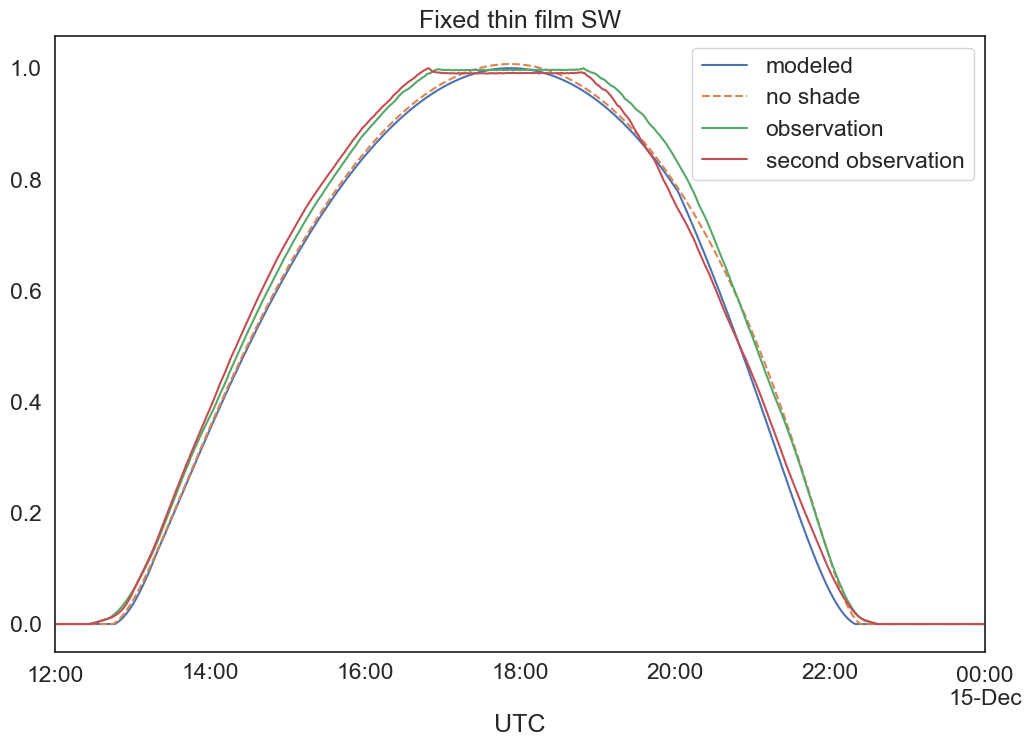

In [12]:
# pick plant/inv unit number:
unit_id = 10
unit_id2 = 11

# date range with clear sky data for the plant
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make plot
clear_sky_comparison_plot(plant_data, times, unit_id, unit_id2)

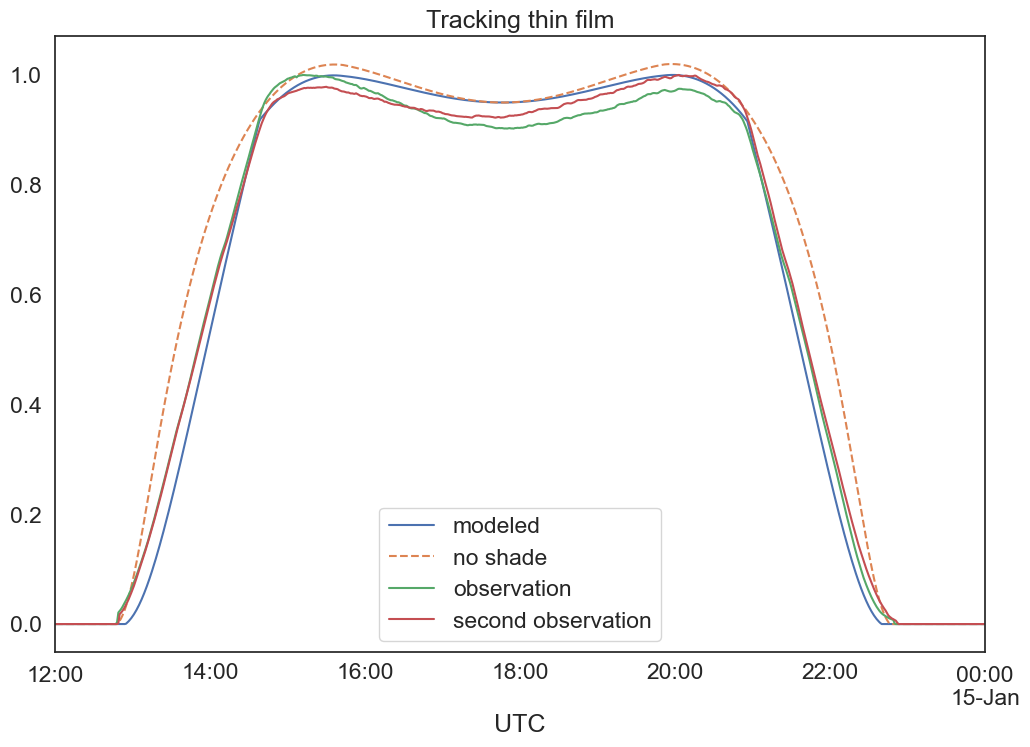

In [13]:
# pick plant/inv unit number:
unit_id = 20
unit_id2 = 21

# date range with clear sky data for the plant
times = pd.date_range('2018-01-14 12:00', '2018-01-15 00:00', freq='1min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make plot
clear_sky_comparison_plot(plant_data, times, unit_id, unit_id2)

Again but with the `isotropic` irradiance model:

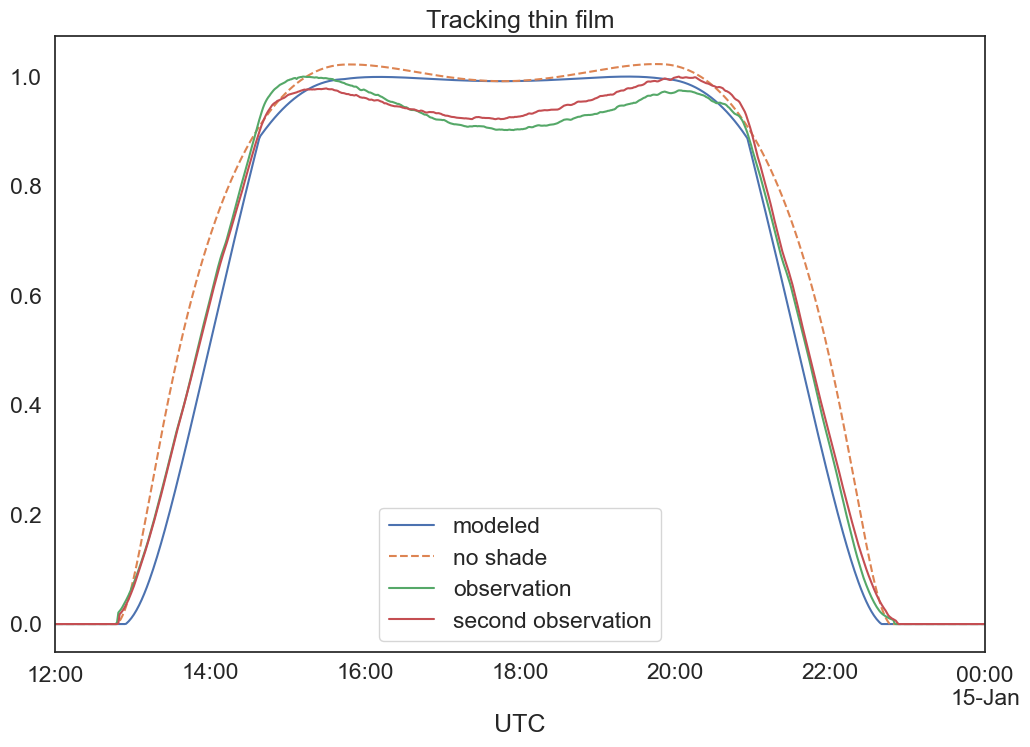

In [14]:
# pick plant/inv unit number:
unit_id = 20
unit_id2 = 21

# date range with clear sky data for the plant
times = pd.date_range('2018-01-14 12:00', '2018-01-15 00:00', freq='1min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# use haydavies model
plant_data_new = { **plant_data,
                  'default_site_transposition_model':'isotropic'
                  }
# make plot
clear_sky_comparison_plot(plant_data_new, times, unit_id, unit_id2)

Those results don't look as good as they did for `haydavies`, at least in terms of shape, noting that the magnitudes of profiles are normalized.

Next plant, back with `haydavies` for the rest:

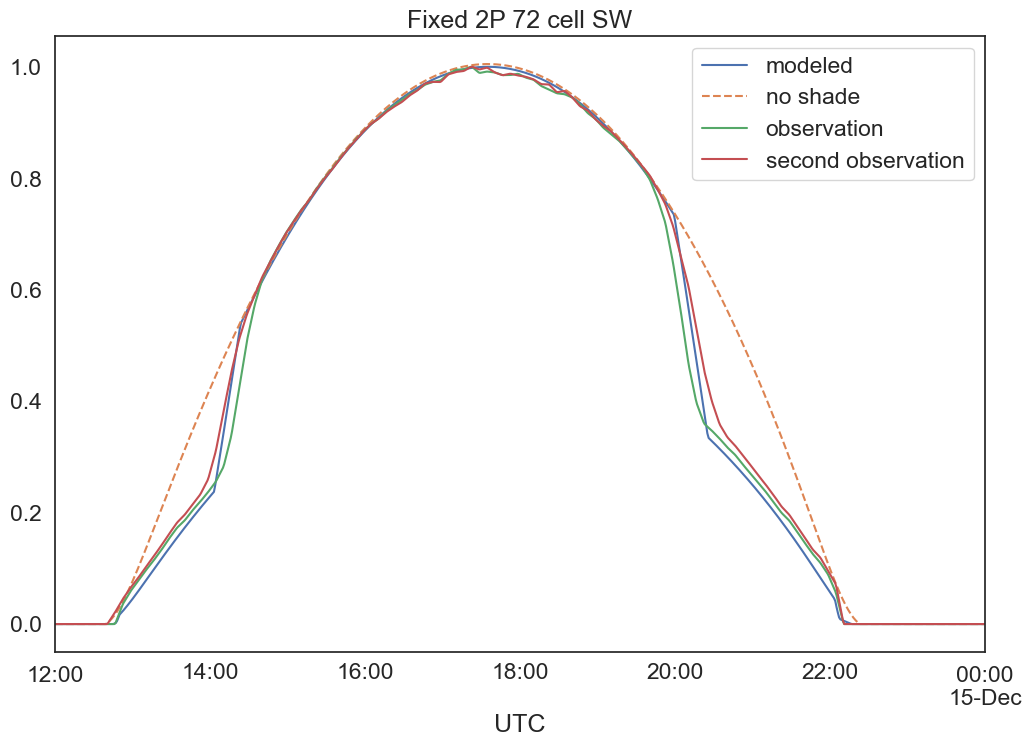

In [15]:
# pick plant/inv unit number:
unit_id = 30
unit_id2 = 31

# date range with clear sky data for the plant
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make plot
clear_sky_comparison_plot(plant_data, times, unit_id, unit_id2)

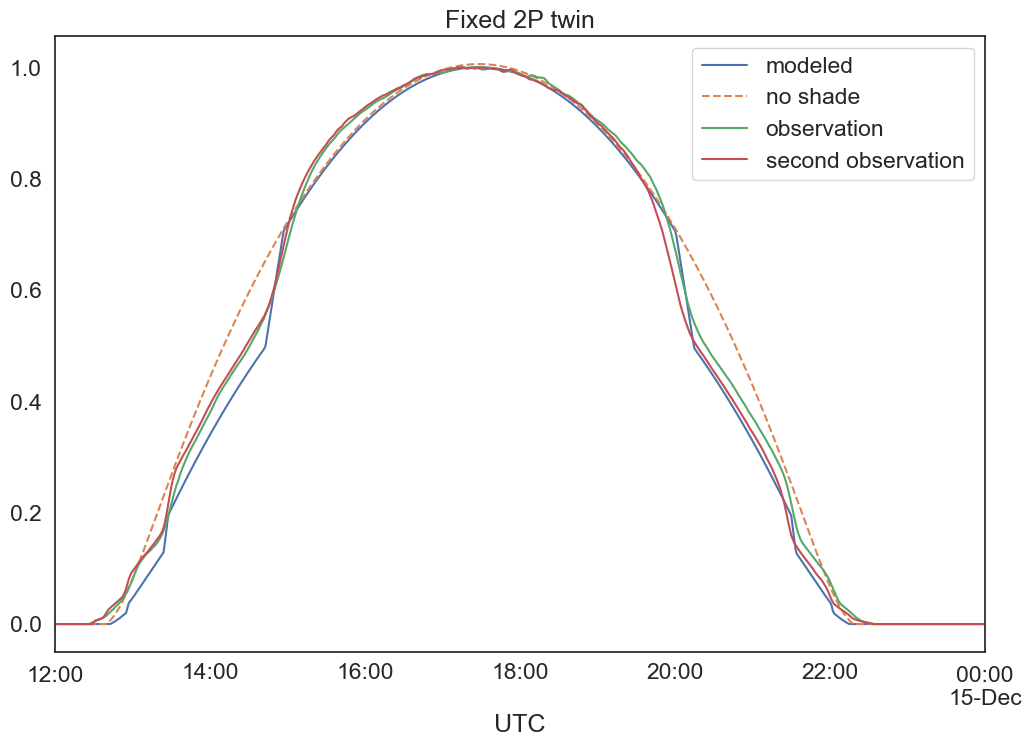

In [16]:
# pick plant/inv unit number:
unit_id = 40
unit_id2 = 41

# date range with clear sky data for the plant
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make plot
clear_sky_comparison_plot(plant_data, times, unit_id, unit_id2)

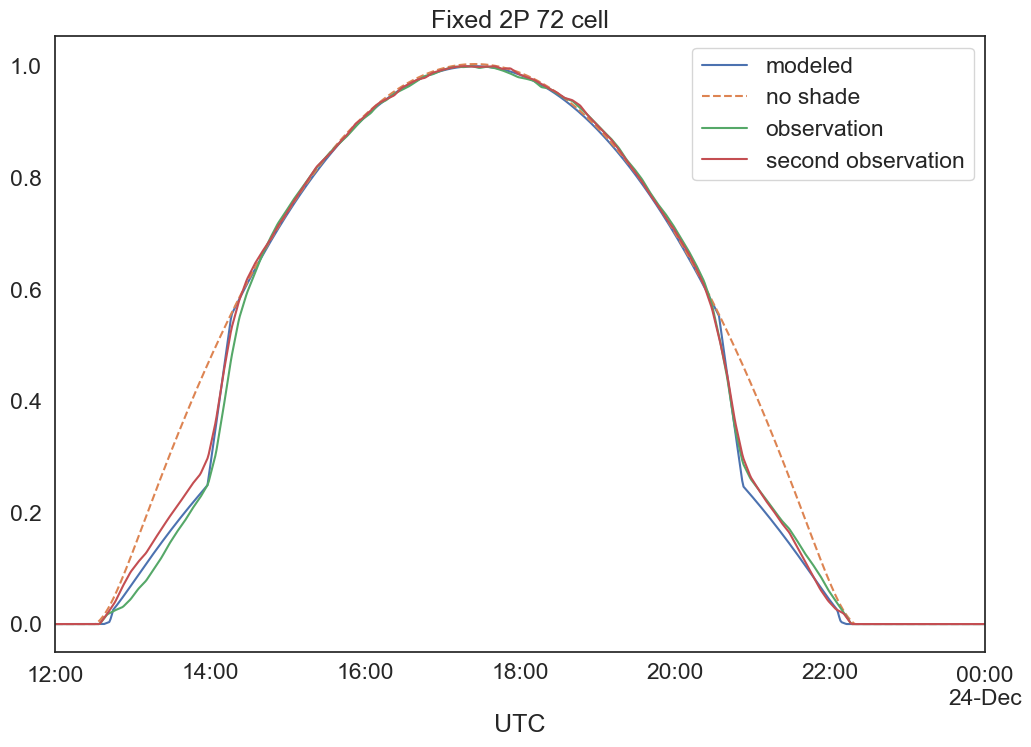

In [17]:
# pick plant/inv unit number:
unit_id = 50
unit_id2 = 51

# date range with clear sky data for the plant
times = pd.date_range('2021-12-23 12:00', '2021-12-24 00:00', freq='1min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make plot
clear_sky_comparison_plot(plant_data, times, unit_id, unit_id2)

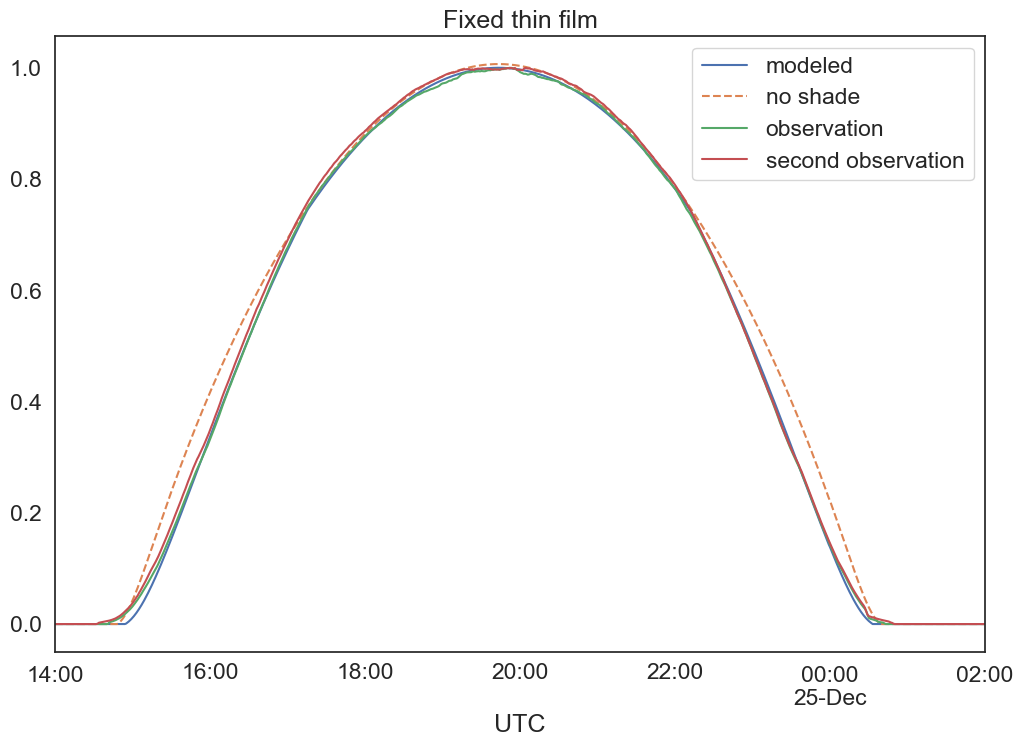

In [18]:
# pick plant/inv unit number:
unit_id = 60
unit_id2 = 61

# date range with clear sky data for the plant
times = pd.date_range('2022-12-24 14:00', '2022-12-25 02:00', freq='1min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make plot
clear_sky_comparison_plot(plant_data, times, unit_id, unit_id2)

Now try with NSRDB:

In [19]:
## API key credentials are stored in a separate text file
try:
    with open('credentials/nrel_api_key_details.txt') as f: # full path and filename of text file with email on first line and api key on second line
        email = f.readline().rstrip()  # rstrip removes trailing line breaks and spaces
        api_key = f.readline().rstrip()
except:
    print('error with email and API key, using temporary defaults')
    print('register at https://developer.nrel.gov/')
    print('create the folder and text file referenced above with email on first line and API key on second line')
    api_key = 'DEMO_KEY'
    email = 'your_email@domain.com'

C:\Users\whobbs\AppData\Local\Temp\ipykernel_40692\2432335923.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resource_data = resource_data.loc[times[0]:times[-1]].resample('1T').interpolate('linear')


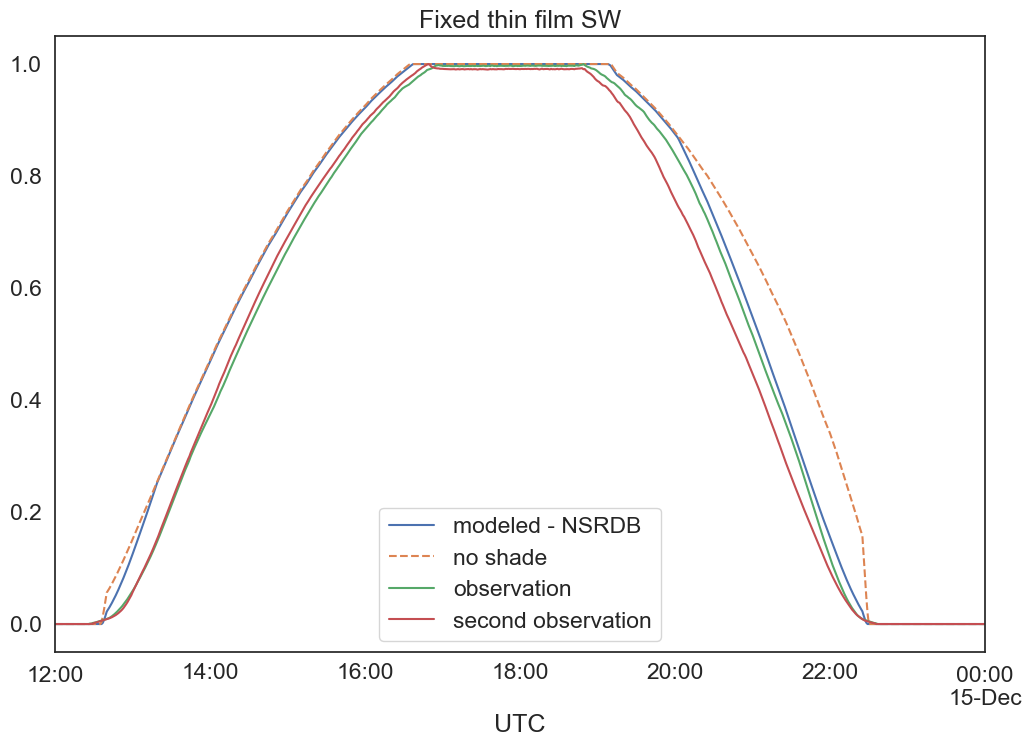

In [20]:
# pick plant/inv unit number:
unit_id = 10
unit_id2 = 11

# date range with clear sky data for the plant
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='5min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make plot
nsrdb_comparison_plot(plant_data, times, api_key, email, clear_sky=True, unit_id=unit_id, unit_id2=unit_id2)

C:\Users\whobbs\AppData\Local\Temp\ipykernel_40692\2432335923.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resource_data = resource_data.loc[times[0]:times[-1]].resample('1T').interpolate('linear')


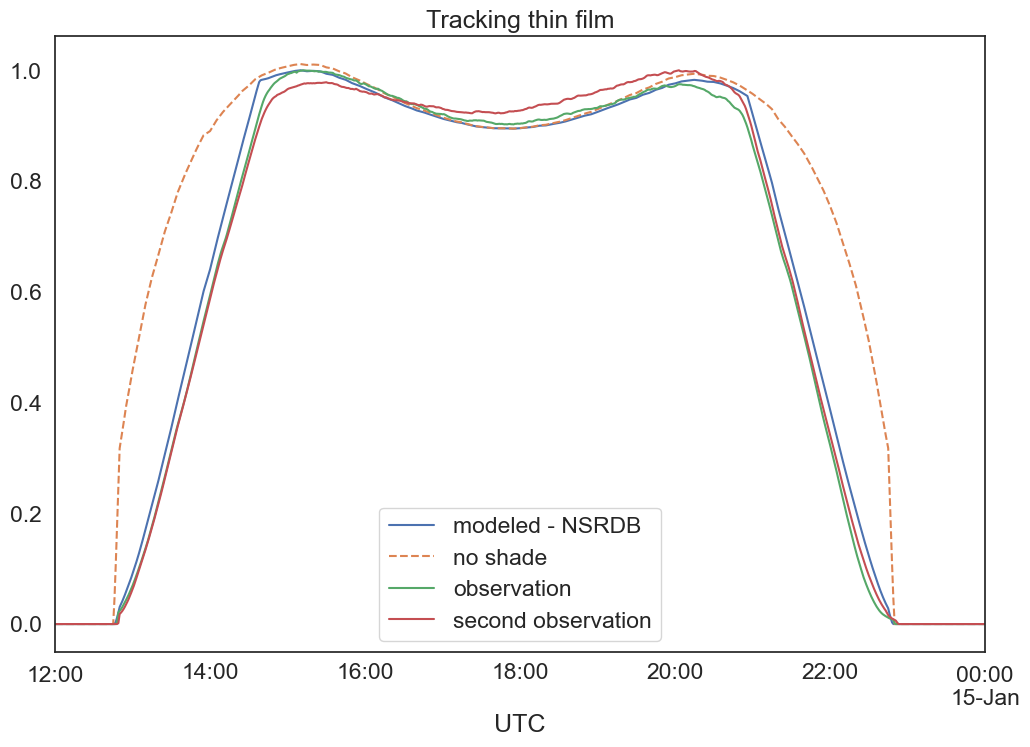

In [21]:
# pick plant/inv unit number:
unit_id = 20
unit_id2 = 21

# date range with clear sky data for the plant
times = pd.date_range('2018-01-14 12:00', '2018-01-15 00:00', freq='1min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make plot
nsrdb_comparison_plot(plant_data, times, api_key, email, clear_sky=True, unit_id=unit_id, unit_id2=unit_id2)

Let's switch to `isotropic` and see what it looks like:

C:\Users\whobbs\AppData\Local\Temp\ipykernel_40692\2432335923.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resource_data = resource_data.loc[times[0]:times[-1]].resample('1T').interpolate('linear')


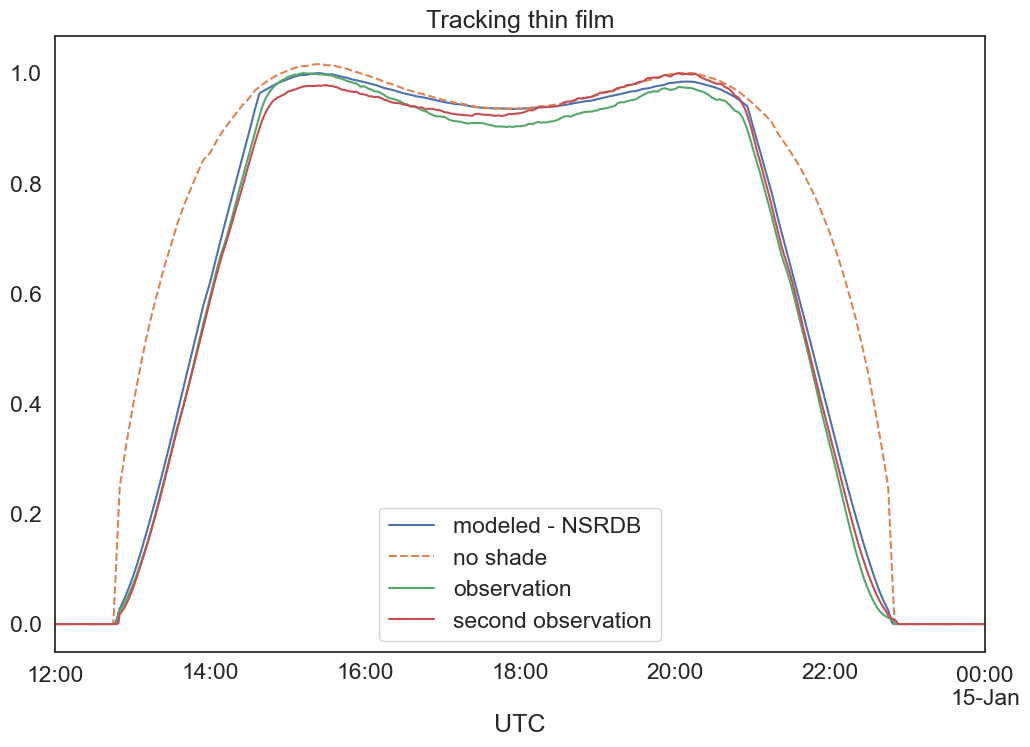

In [22]:
plant_data = {
    **plant_data,
    'default_site_transposition_model': 'isotropic',
}

# make plot
nsrdb_comparison_plot(plant_data, times, api_key, email, clear_sky=True, unit_id=unit_id, unit_id2=unit_id2)

And continue on to additional plants using `haydavies`:

C:\Users\whobbs\AppData\Local\Temp\ipykernel_40692\2432335923.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resource_data = resource_data.loc[times[0]:times[-1]].resample('1T').interpolate('linear')


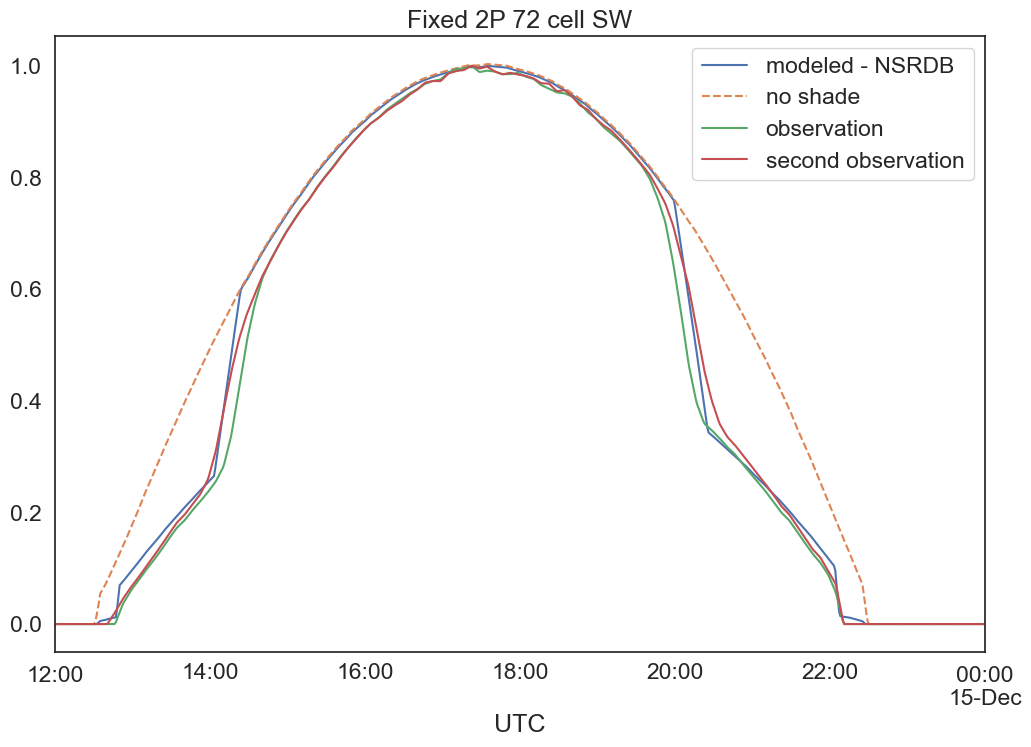

In [23]:
# pick plant/inv unit number:
unit_id = 30
unit_id2 = 31

# date range with clear sky data for the plant
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='5min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
plant_data = {
    **plant_data,
}

# make plot
nsrdb_comparison_plot(plant_data, times, api_key, email, clear_sky=True, unit_id=unit_id, unit_id2=unit_id2)

C:\Users\whobbs\AppData\Local\Temp\ipykernel_40692\2432335923.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resource_data = resource_data.loc[times[0]:times[-1]].resample('1T').interpolate('linear')


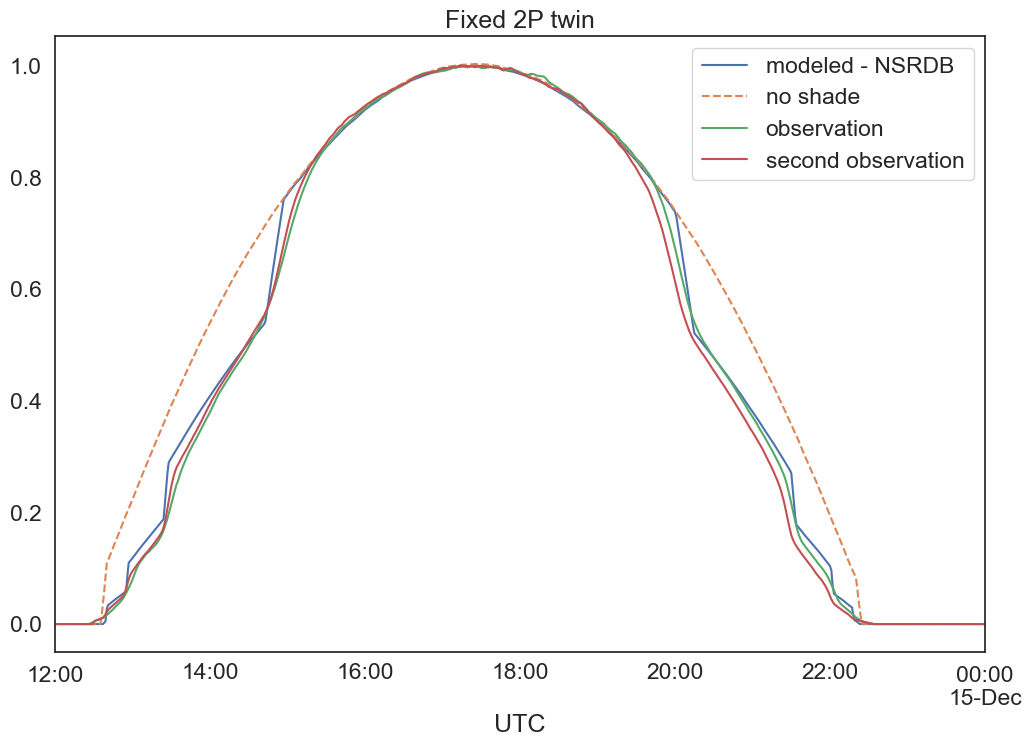

In [24]:
# pick plant/inv unit number:
unit_id = 40
unit_id2 = 41

# date range with clear sky data for the plant
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='5min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
plant_data = {
    **plant_data,
}

# make plot
nsrdb_comparison_plot(plant_data, times, api_key, email, clear_sky=True, unit_id=unit_id, unit_id2=unit_id2)

C:\Users\whobbs\AppData\Local\Temp\ipykernel_40692\2432335923.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resource_data = resource_data.loc[times[0]:times[-1]].resample('1T').interpolate('linear')


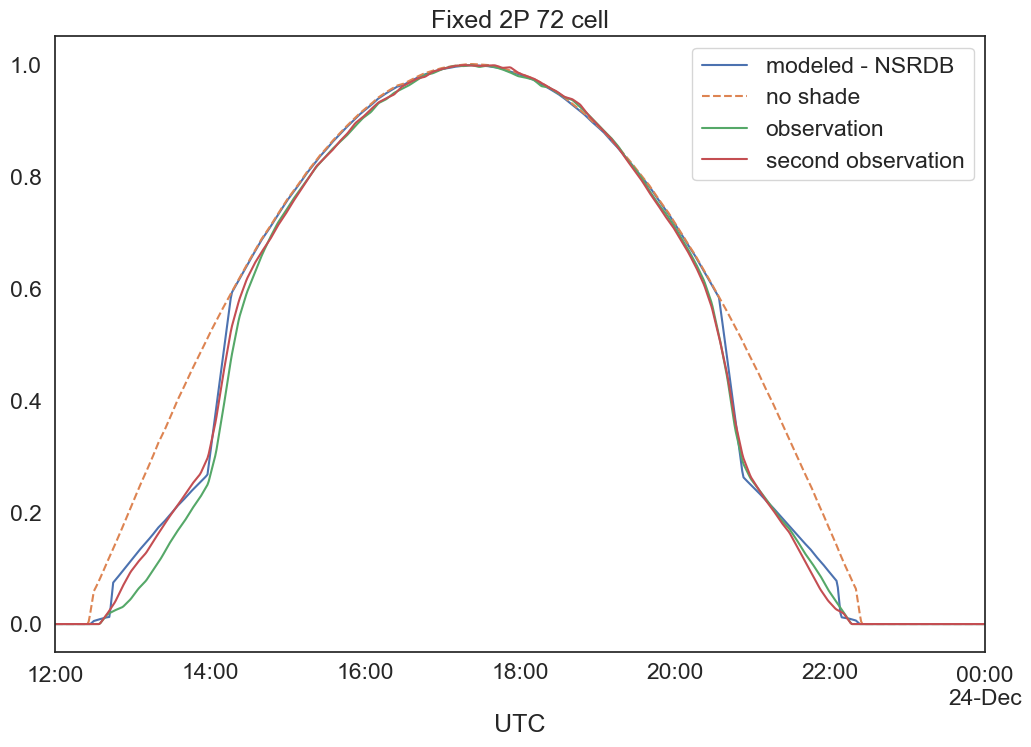

In [25]:
# pick plant/inv unit number:
unit_id = 50
unit_id2 = 51

# date range with clear sky data for the plant
times = pd.date_range('2021-12-23 12:00', '2021-12-24 00:00', freq='5min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
plant_data = {
    **plant_data,
}
# make plot
nsrdb_comparison_plot(plant_data, times, api_key, email, clear_sky=True, unit_id=unit_id, unit_id2=unit_id2)

C:\Users\whobbs\AppData\Local\Temp\ipykernel_40692\2432335923.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resource_data = resource_data.loc[times[0]:times[-1]].resample('1T').interpolate('linear')


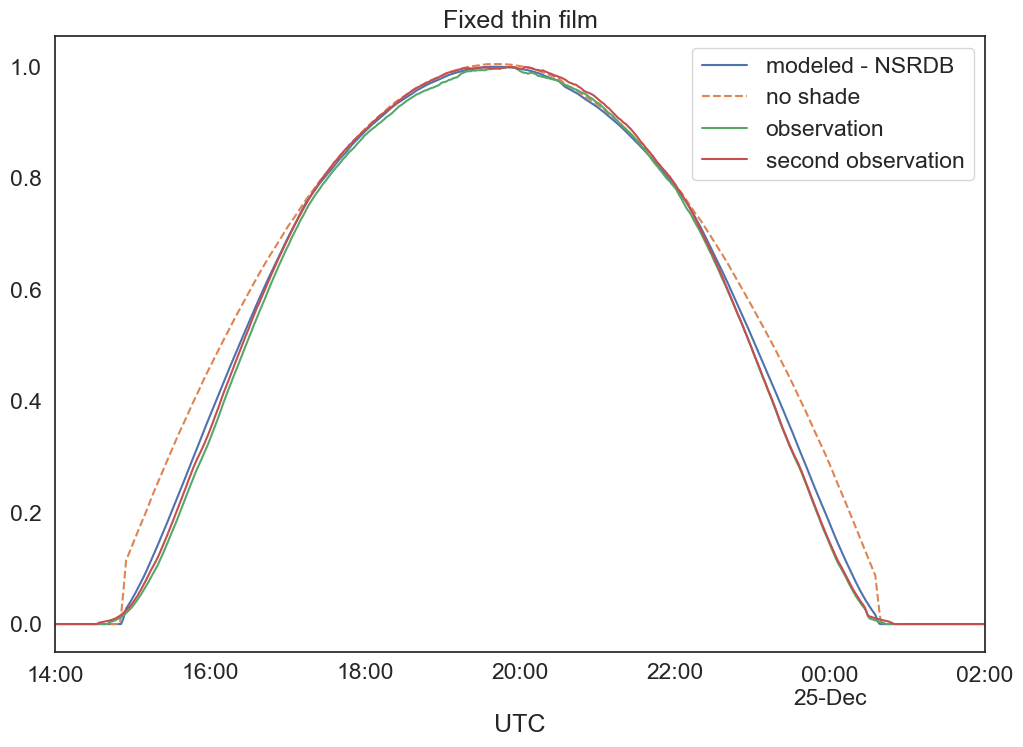

In [26]:
# pick plant/inv unit number:
unit_id = 60
unit_id2 = 61

# date range with clear sky data for the plant
times = pd.date_range('2022-12-24 14:00', '2022-12-25 02:00', freq='5min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
plant_data = {
    **plant_data,
}
# make plot
nsrdb_comparison_plot(plant_data, times, api_key, email, clear_sky=True, unit_id=unit_id, unit_id2=unit_id2)